## **InfoGAN**

InfoGAN is another approach for generating disentangled outputs. In this architecture, the generator takes two inputs which are **Z** the random noise and **C** the latent code.

![](infoGAN.PNG)
<br>
<br>
InfoGAN is defined as the following minimax game with a variational regularization of
mutual information and a hyperparameter λ:
Eq (6)![](formulaInfoGAN.PNG)

In [16]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.distributions.normal import Normal
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np
import math
from tqdm.auto import tqdm

In [2]:
def show(images, n_images, n_rows, show=True):
  grid = (make_grid(((images + 1) / 2).detach().cpu()[:n_images], nrow=n_rows)).permute(1,2,0).squeeze()
  plt.imshow(grid)
  if show:
    plt.show()

## Dataset exploration

In [3]:
transform = transforms.Compose([
    # transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
    # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [4]:
dataset = datasets.MNIST('MNIST', train=True,
                           transform=transform, download=True)
data_loader = DataLoader(dataset, batch_size=128,
                         shuffle=True)

In [5]:
for i, image in enumerate(data_loader):
  img = image[0]

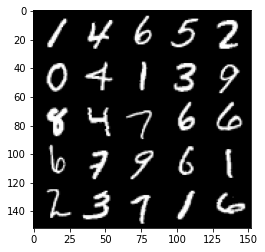

In [6]:
show(img, 25, 5)

## **Generator**

In [7]:
def generator_block(input, output, kernel_size=3, stride=2, last_layer=False):
  if not last_layer:
    x = nn.Sequential(
        nn.ConvTranspose2d(input, output, kernel_size, stride),
        nn.BatchNorm2d(output),
        nn.ReLU(inplace=True)
    )
  else:
    x = nn.Sequential(
        nn.ConvTranspose2d(input, output, kernel_size, stride),
        nn.Tanh()
    )
  return x

In [8]:
class Generator(nn.Module):
  def __init__(self, noise_dim, image_dim, hidden_dim):
    super(Generator, self).__init__()
    self.noise_dim = noise_dim
    self.generator = nn.Sequential(
        generator_block(noise_dim, hidden_dim * 4),
        generator_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
        generator_block(hidden_dim * 2, hidden_dim),
        generator_block(hidden_dim, image_dim, kernel_size=4, last_layer=True)
    )
  def forward(self, noise):
    noise = noise.view(len(noise), self.noise_dim, 1, 1)
    x = self.generator(noise)
    return x

In [9]:
def get_noise_vectors(n_samples, noise_dim, device='cpu'):
  return torch.randn(n_samples, noise_dim, device=device)

## **Discriminator**

In [10]:
def discriminator_block(input, output, kernel_size=4, stride=2, last_layer=False):
  if not last_layer:
    x = nn.Sequential(
        nn.Conv2d(input, output, kernel_size, stride),
        nn.BatchNorm2d(output),
        nn.LeakyReLU(0.2, inplace=True)
    )
  else:
    x = nn.Sequential(
        nn.Conv2d(input, output, kernel_size, stride)
    )
  return x

In [11]:
class Discriminator(nn.Module):
  def __init__(self, image_dim, hidden_dim, c):
    super(Discriminator, self).__init__()
    self.discr = nn.Sequential(
        discriminator_block(image_dim, hidden_dim),
        discriminator_block(hidden_dim, hidden_dim * 2)
    )
    self.layer_d = discriminator_block(hidden_dim * 2, 1, last_layer=True)
    self.layer_q = nn.Sequential(
        discriminator_block(hidden_dim * 2, hidden_dim * 2),
        discriminator_block(hidden_dim * 2, 2 * c, kernel_size=1, last_layer=True)
    )
  
  def forward(self, image):
    pred_init = self.discr(image)
    pred_discr = self.layer_d(pred_init)
    pred_layer_q = self.layer_q(pred_init)
    return pred_discr.view(len(pred_discr), -1), pred_layer_q.view(len(pred_layer_q), -1)

In [12]:
def concat_vectors(a, b):
  concat = torch.cat([a.float(), b.float()], 1)
  return concat

## **Training**

In [13]:
criterion = nn.BCEWithLogitsLoss()
mut_criterion = lambda c_true, mean, logvar: Normal(mean, logvar.exp()).log_prob(c_true).mean()
c_lambda = 0.1
image_shape = (1,28,28)
image_channels = 1
noise_dim = 64
hidden_dim = 64
c_dim = 2
epochs = 50
batch_size = 128
device = 'cuda'
step = 500

g_lr = 1e-3
d_lr = 2e-4

In [14]:
generator = Generator(noise_dim + c_dim, image_channels, hidden_dim).to(device)
gen_optim = torch.optim.Adam(generator.parameters(), lr=g_lr)
discr = Discriminator(image_channels, hidden_dim, c_dim).to(device)
discr_optim = torch.optim.Adam(discr.parameters(), lr=d_lr)

def weights_init(layer):
    if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.ConvTranspose2d):
        torch.nn.init.normal_(layer.weight, 0.0, 0.02)
    if isinstance(layer, nn.BatchNorm2d):
        torch.nn.init.normal_(layer.weight, 0.0, 0.02)
        torch.nn.init.constant_(layer.bias, 0)
generator = generator.apply(weights_init)
discr = discr.apply(weights_init)

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1, step 500: Generator loss: 0.7792941726446152, discriminator loss: 0.7513102205395699


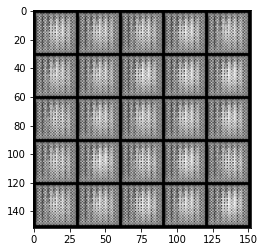

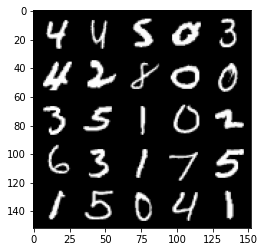

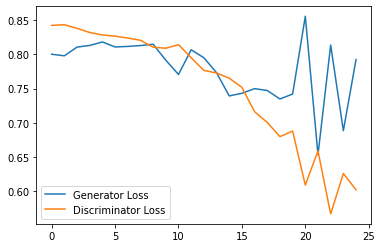

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2, step 1000: Generator loss: 1.3534493327140809, discriminator loss: 0.36437810492515565


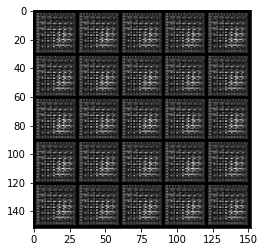

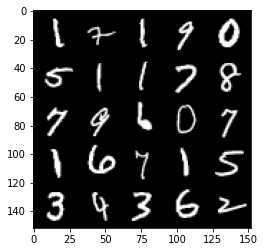

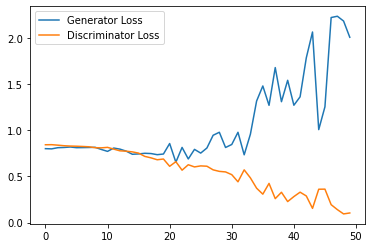

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3, step 1500: Generator loss: 2.6415733551979064, discriminator loss: 0.084928696192801


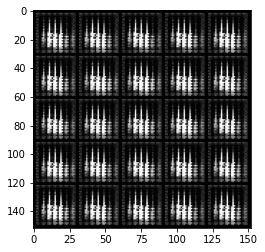

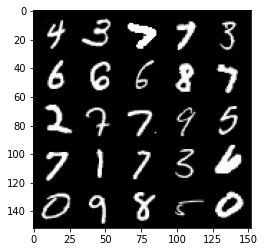

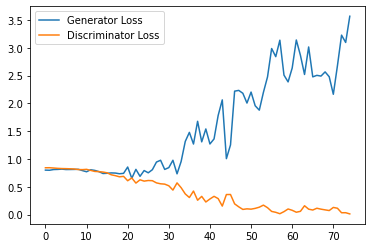

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4, step 2000: Generator loss: 2.9802663207054136, discriminator loss: 0.07974132633581757


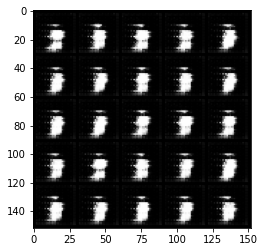

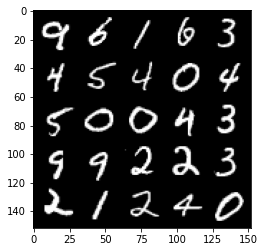

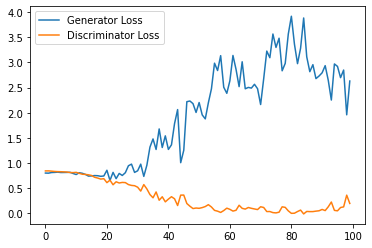

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5, step 2500: Generator loss: 2.158807778596878, discriminator loss: 0.35575094787031414


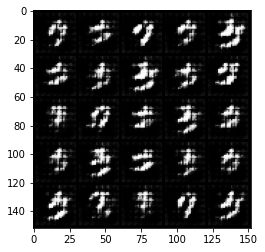

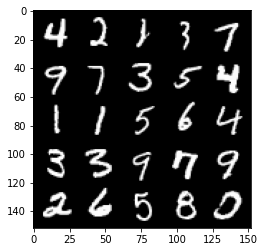

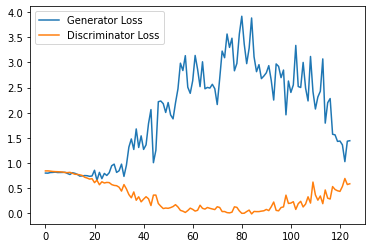

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6, step 3000: Generator loss: 1.4924351063966752, discriminator loss: 0.4799854029417038


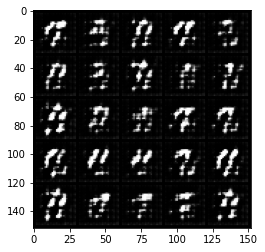

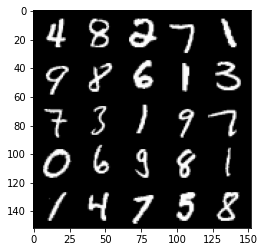

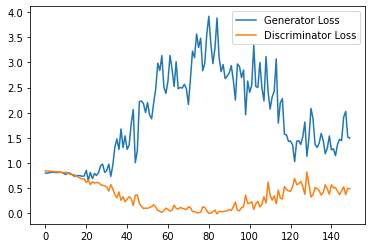

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7, step 3500: Generator loss: 1.6135312333106995, discriminator loss: 0.4005716474950314


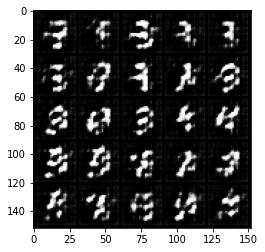

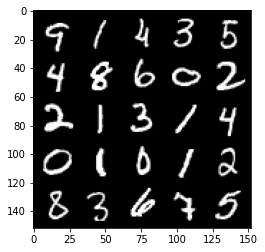

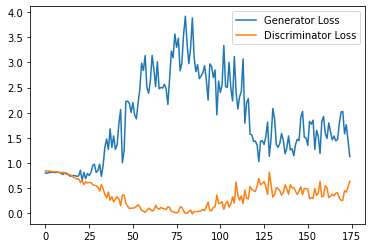

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8, step 4000: Generator loss: 1.4985915632247926, discriminator loss: 0.44267340767383573


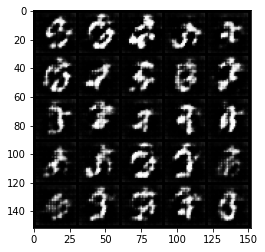

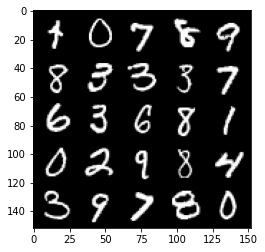

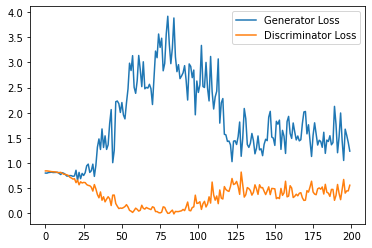

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9, step 4500: Generator loss: 1.537431035041809, discriminator loss: 0.47239286464452745


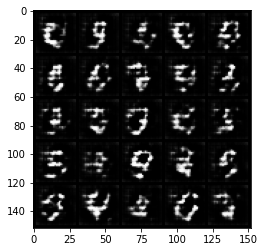

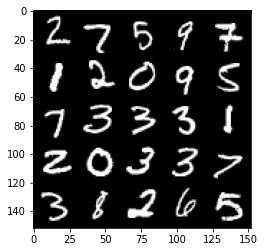

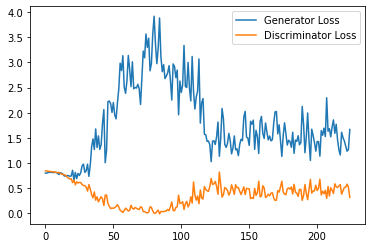

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10, step 5000: Generator loss: 1.5569758268594742, discriminator loss: 0.43823384830355644


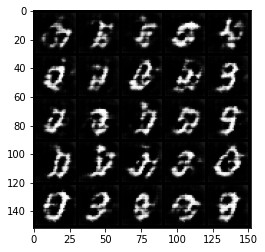

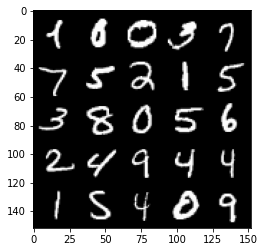

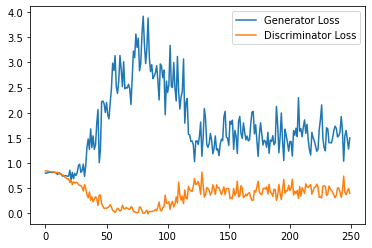

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 11, step 5500: Generator loss: 1.5859327487945556, discriminator loss: 0.39090156853199004


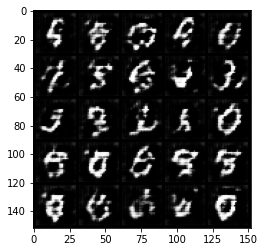

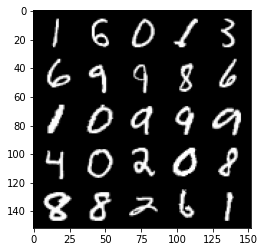

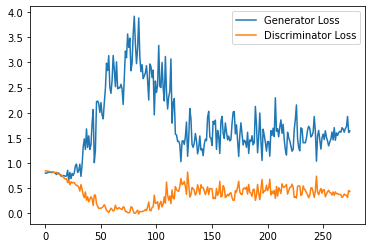

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 12, step 6000: Generator loss: 1.8591177883148193, discriminator loss: 0.39321532180905344


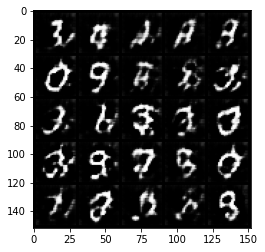

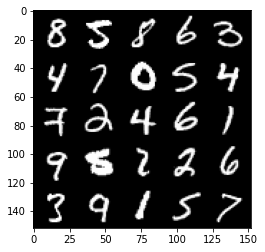

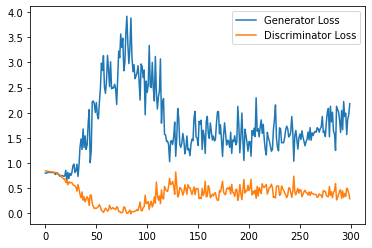

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 13, step 6500: Generator loss: 1.6457467535734176, discriminator loss: 0.44359727668762206


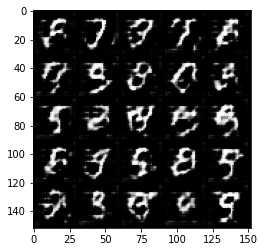

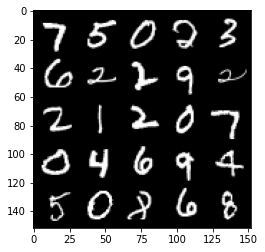

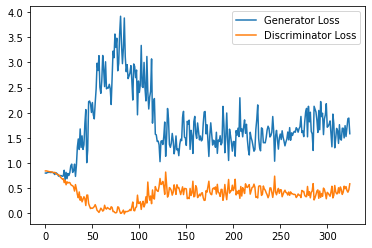

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 14, step 7000: Generator loss: 1.4830932124853133, discriminator loss: 0.5006526215672493


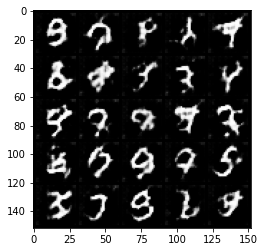

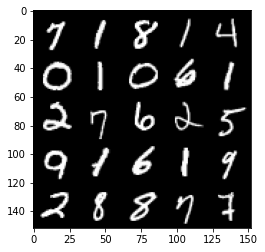

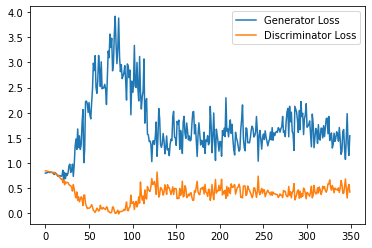

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 15, step 7500: Generator loss: 1.459039081454277, discriminator loss: 0.4847169682085514


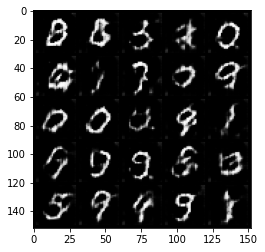

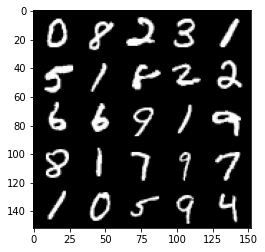

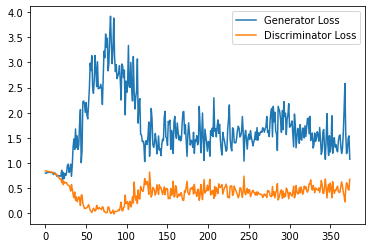

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 17, step 8000: Generator loss: 1.401122078895569, discriminator loss: 0.4948329883813858


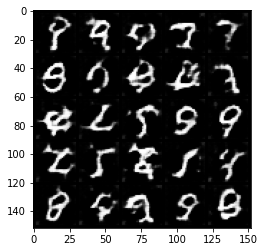

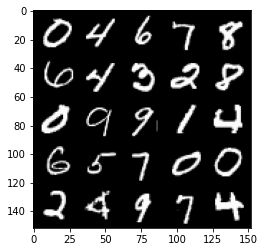

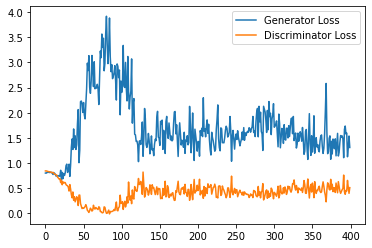

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 18, step 8500: Generator loss: 1.3432607904672622, discriminator loss: 0.496504388988018


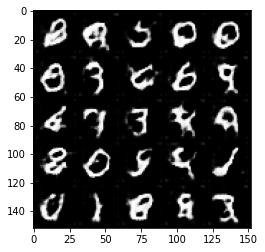

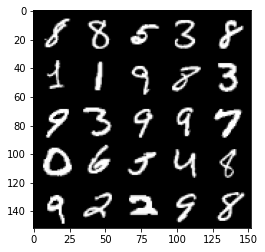

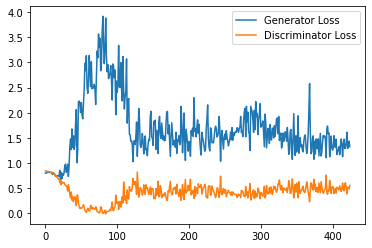

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 19, step 9000: Generator loss: 1.4097216078042984, discriminator loss: 0.5072258149981499


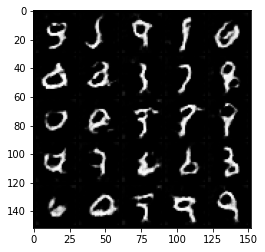

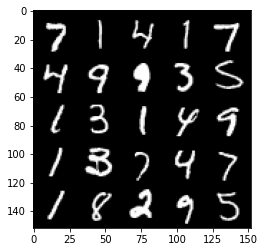

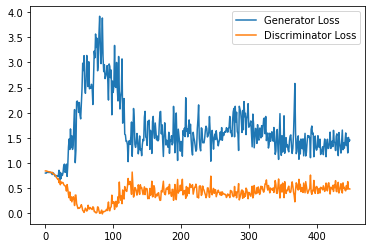

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 20, step 9500: Generator loss: 1.3293512684106827, discriminator loss: 0.5147690731883049


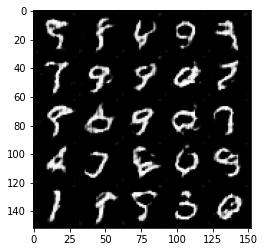

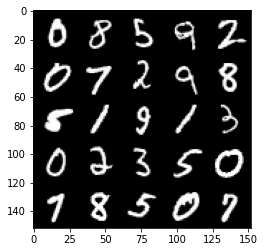

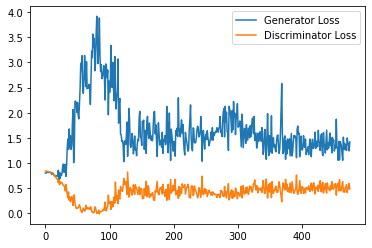

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 21, step 10000: Generator loss: 1.2972568666934967, discriminator loss: 0.5311381221413612


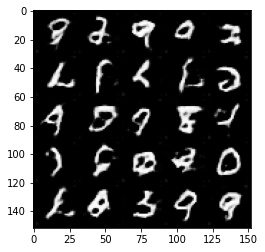

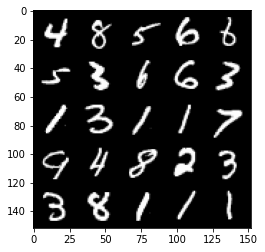

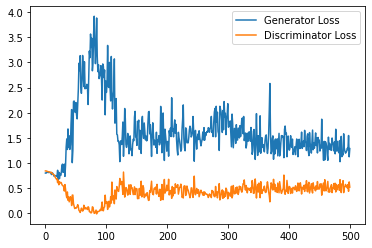

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 22, step 10500: Generator loss: 1.2780114008188248, discriminator loss: 0.5452208826541901


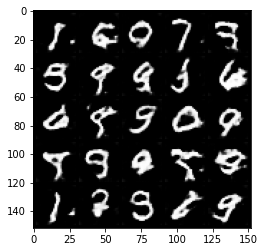

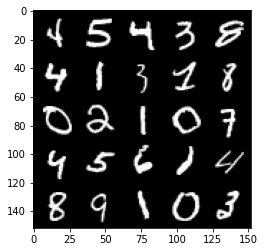

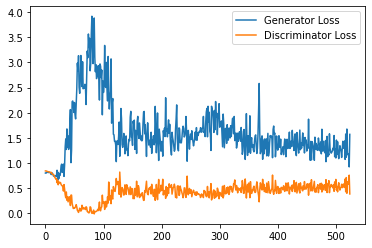

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 23, step 11000: Generator loss: 1.2495765577554703, discriminator loss: 0.5501505148410797


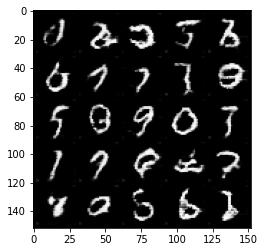

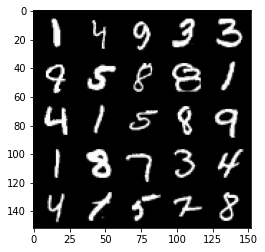

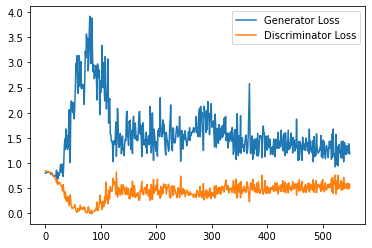

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 24, step 11500: Generator loss: 1.270443515062332, discriminator loss: 0.5451138330101967


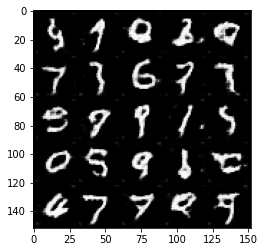

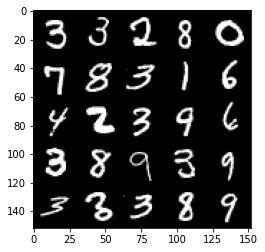

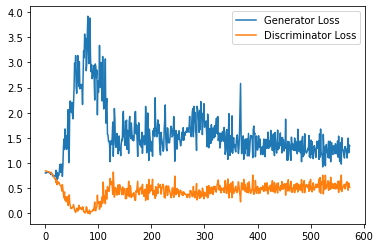

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 25, step 12000: Generator loss: 1.2697235198020935, discriminator loss: 0.5439971304535866


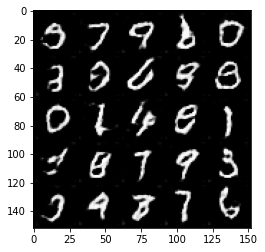

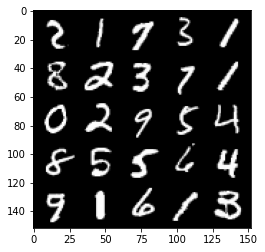

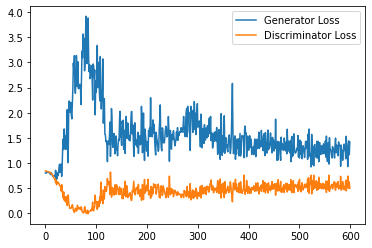

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 26, step 12500: Generator loss: 1.2317562099695205, discriminator loss: 0.5596114549040795


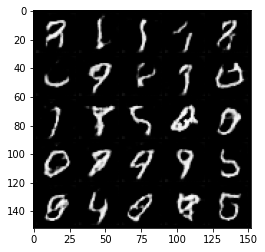

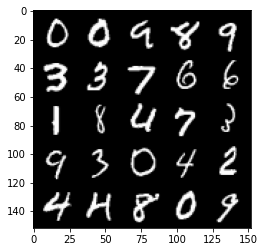

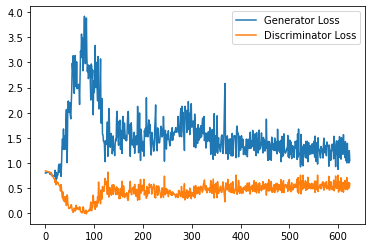

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 27, step 13000: Generator loss: 1.1943259011507035, discriminator loss: 0.5498653763532638


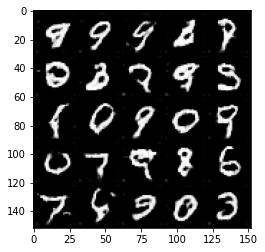

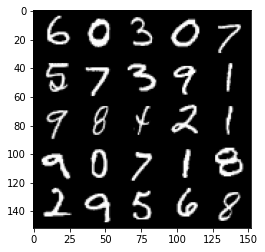

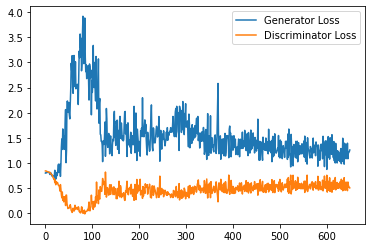

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 28, step 13500: Generator loss: 1.1958624033927918, discriminator loss: 0.5578678055405617


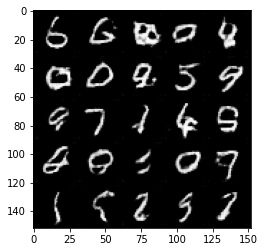

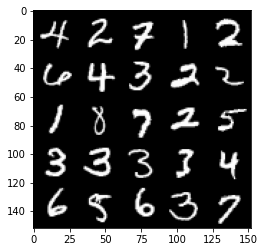

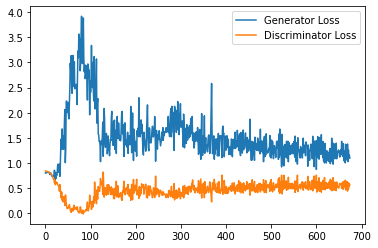

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 29, step 14000: Generator loss: 1.1728453294038772, discriminator loss: 0.5495248926281929


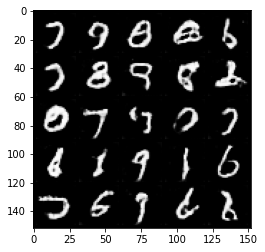

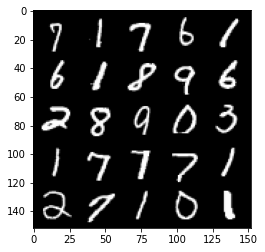

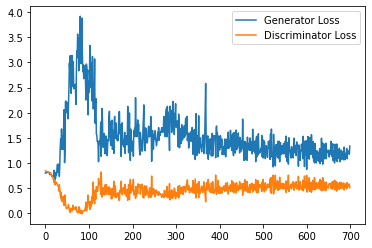

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 30, step 14500: Generator loss: 1.1409476149082183, discriminator loss: 0.564704874753952


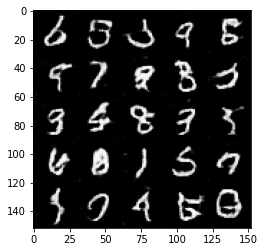

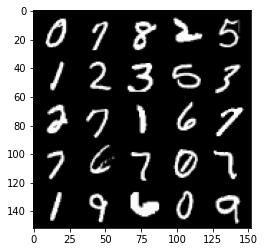

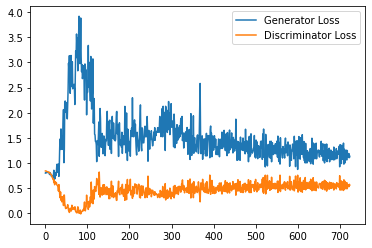

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 31, step 15000: Generator loss: 1.1791072643995284, discriminator loss: 0.5612109915018082


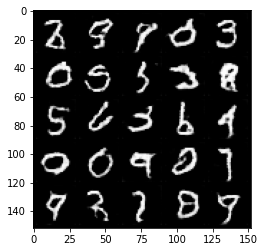

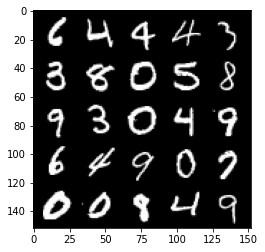

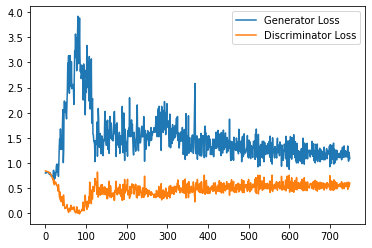

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 33, step 15500: Generator loss: 1.1343236366510392, discriminator loss: 0.5588279511332512


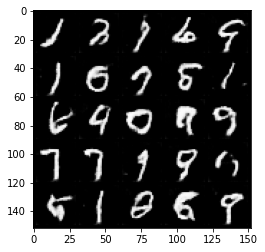

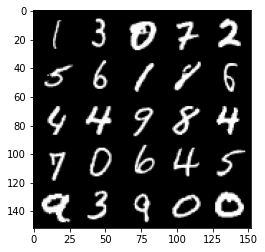

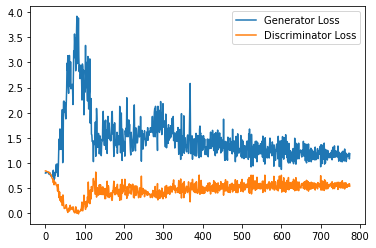

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 34, step 16000: Generator loss: 1.1920728586912155, discriminator loss: 0.5617878673672676


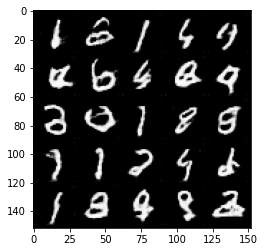

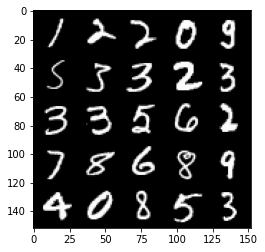

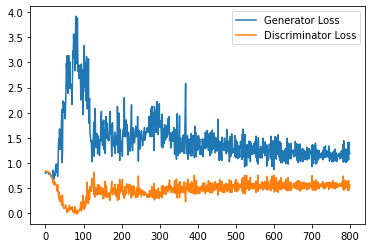

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 35, step 16500: Generator loss: 1.1396867676973343, discriminator loss: 0.5603780062794685


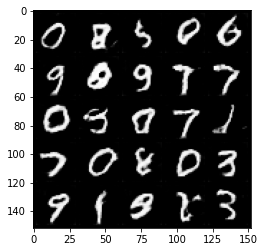

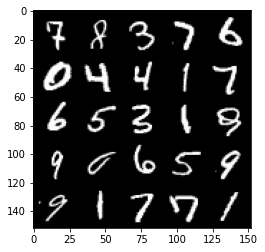

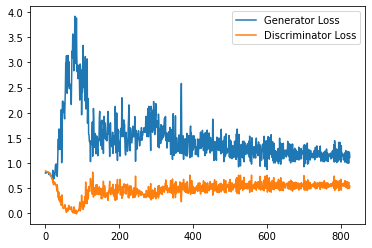

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 36, step 17000: Generator loss: 1.141202966928482, discriminator loss: 0.5626666135191918


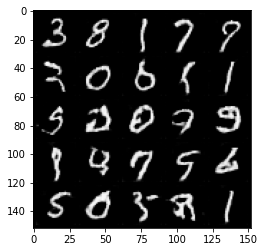

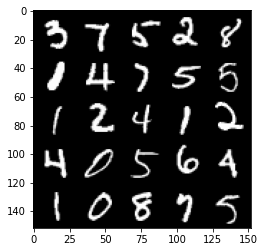

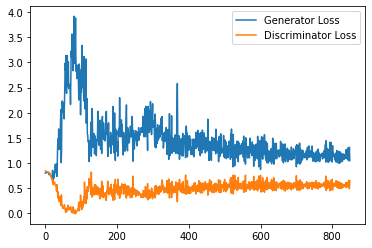

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 37, step 17500: Generator loss: 1.1368386890888214, discriminator loss: 0.5642202252149582


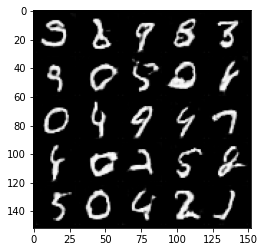

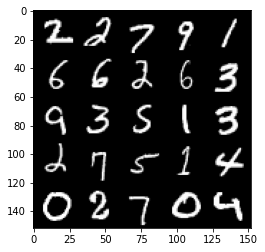

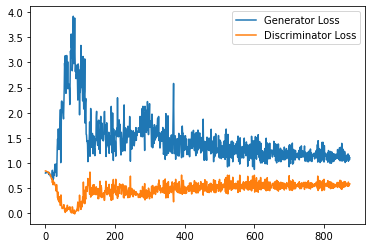

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 38, step 18000: Generator loss: 1.1034023011922836, discriminator loss: 0.5673894383907319


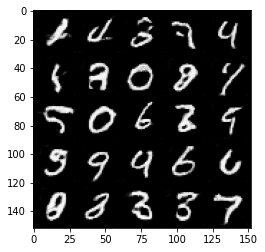

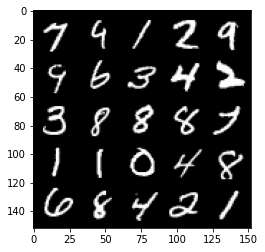

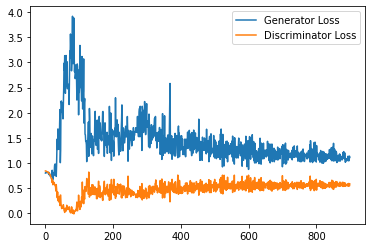

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 39, step 18500: Generator loss: 1.1118089570999146, discriminator loss: 0.5599355034828186


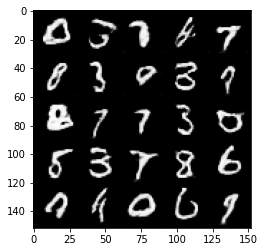

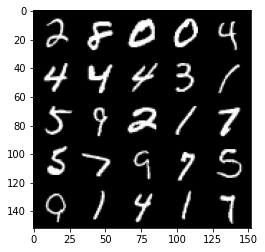

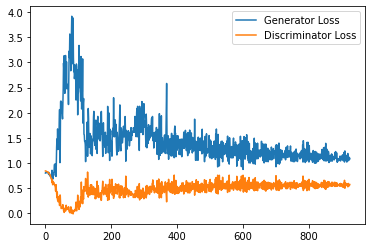

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 40, step 19000: Generator loss: 1.106069531917572, discriminator loss: 0.5609810165762902


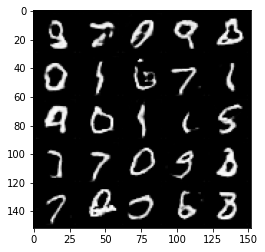

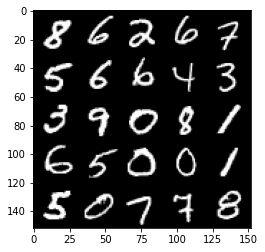

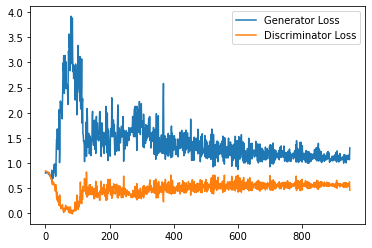

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 41, step 19500: Generator loss: 1.0876947798728942, discriminator loss: 0.5644459891915321


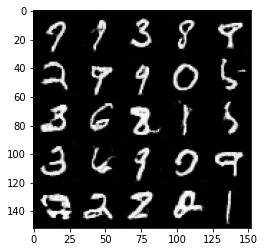

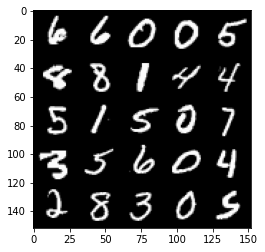

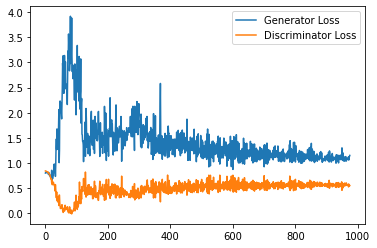

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 42, step 20000: Generator loss: 1.1413610523939133, discriminator loss: 0.5727557406425476


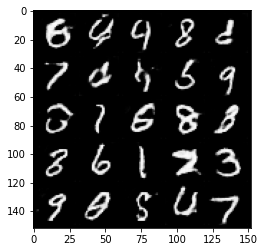

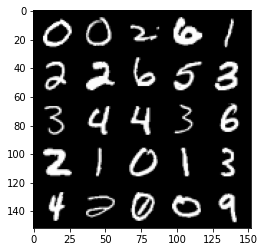

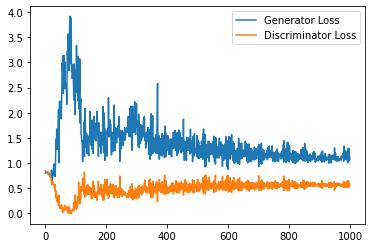

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 43, step 20500: Generator loss: 1.106295027256012, discriminator loss: 0.5699064491391181


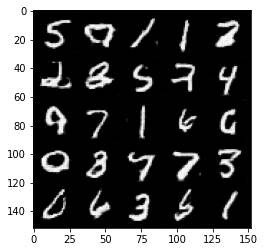

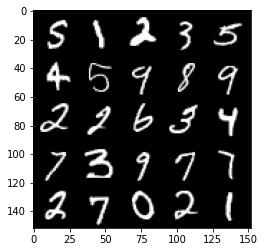

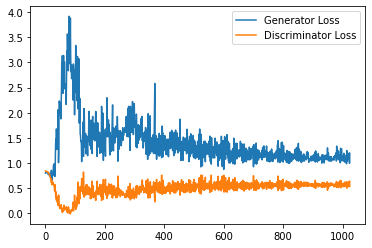

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 44, step 21000: Generator loss: 1.133447359919548, discriminator loss: 0.5724431232213975


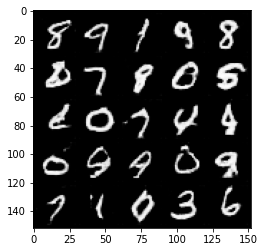

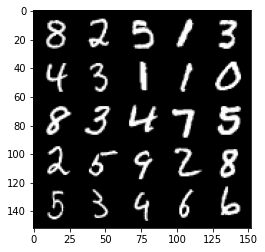

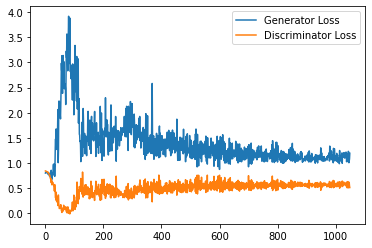

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 45, step 21500: Generator loss: 1.1017521592378616, discriminator loss: 0.5743365941643714


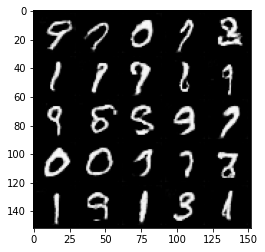

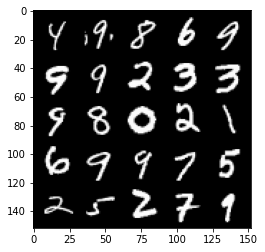

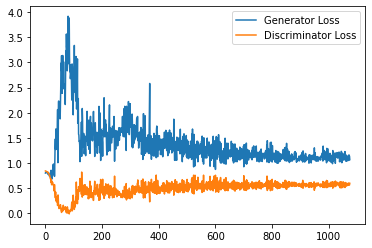

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 46, step 22000: Generator loss: 1.0796443176269532, discriminator loss: 0.5775500479936599


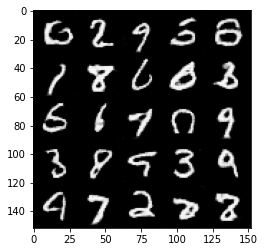

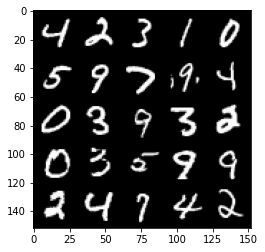

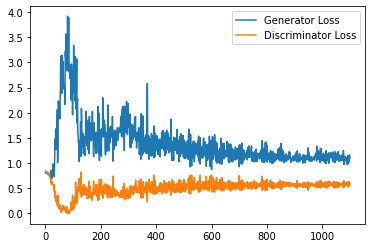

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 47, step 22500: Generator loss: 1.0663891627788544, discriminator loss: 0.5762843081355095


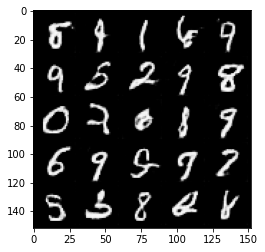

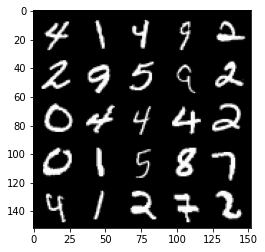

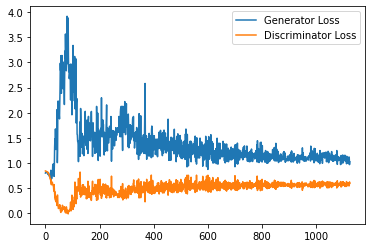

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 49, step 23000: Generator loss: 1.1079290410280227, discriminator loss: 0.5731041017174721


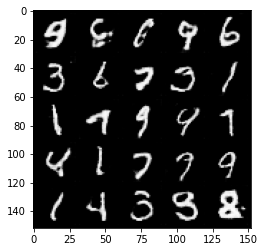

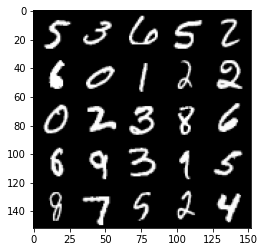

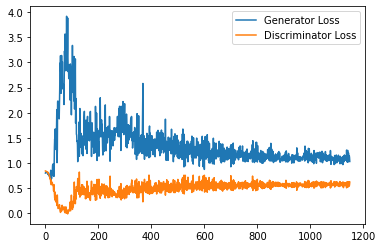

In [15]:
cur_step = 0
gen_losses = []
disc_losses = []

for epoch in range(epochs):
  for image, _ in tqdm(data_loader):
    cur_batch_size = len(image)
    image = image.to(device)
    c_labels = get_noise_vectors(cur_batch_size, c_dim, device=device)

    # Update Discriminator
    discr_optim.zero_grad()
    fake_noise = get_noise_vectors(cur_batch_size, noise_dim, device=device)
    noise_cat_labels = concat_vectors(fake_noise, c_labels)
    fake = generator(noise_cat_labels)

    # Discriminator Predictions
    disc_fake_pred, disc_q_pred = discr(fake.detach())
    disc_q_mean = disc_q_pred[:, :c_dim]
    disc_q_logvar = disc_q_pred[:, c_dim:]
    mut_info = mut_criterion(c_labels, disc_q_mean, disc_q_logvar)
    disc_real_pred, _ = discr(image)
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
    disc_loss = (disc_fake_loss + disc_real_loss) / 2 - c_lambda * mut_info
    disc_loss.backward(retain_graph=True)
    discr_optim.step()
    disc_losses += [disc_loss.item()]

    # Update Generator
    gen_optim.zero_grad()
    disc_fake_pred, disc_q_pred = discr(fake)
    disc_q_mean = disc_q_pred[:, :c_dim]
    disc_q_logvar = disc_q_pred[:, c_dim:]
    mut_info = mut_criterion(c_labels, disc_q_mean, disc_q_logvar)
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred)) - c_lambda * mut_info
    gen_loss.backward()
    gen_optim.step()
    gen_losses += [gen_loss.item()]

    if cur_step % step == 0 and cur_step > 0:
      gen_mean = sum(gen_losses[-step:]) / step
      disc_mean = sum(disc_losses[-step:]) / step
      print(f"Epoch {epoch}, step {cur_step}: Generator loss: {gen_mean}, discriminator loss: {disc_mean}")
      show(fake, 25, 5)
      show(image, 25, 5)
      step_bins = 20
      x_axis = sorted([i * step_bins for i in range(len(gen_losses) // step_bins)] * step_bins)
      num_examples = (len(gen_losses) // step_bins) * step_bins
      plt.plot(
          range(num_examples // step_bins), 
          torch.Tensor(gen_losses[:num_examples]).view(-1, step_bins).mean(1),
          label="Generator Loss"
      )
      plt.plot(
          range(num_examples // step_bins), 
          torch.Tensor(disc_losses[:num_examples]).view(-1, step_bins).mean(1),
          label="Discriminator Loss"
      )
      plt.legend()
      plt.show()
    cur_step += 1

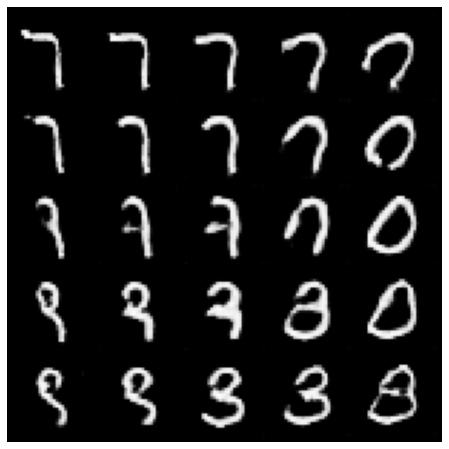

In [32]:
generator = generator.eval()
n = 5

def interpolate_noise():
  intrp_noise = get_noise_vectors(1, noise_dim, device=device).repeat(n * n, 1)
  l_1 = get_noise_vectors(1, c_dim).repeat(n * n, 1)
  l_1 = torch.linspace(-2, 2, n).repeat(n)
  l_2 = torch.linspace(-2, 2, n).repeat_interleave(n)
  intrp_label = torch.stack([l_1, l_2], dim=1)
  noise_cat_label = concat_vectors(intrp_noise, intrp_label.to(device))
  fake = generator(noise_cat_label)
  show(fake, n * n, n, show=False)

plt.figure(figsize=(8, 8))
interpolate_noise()
_ = plt.axis('off')